In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive
import shutil
import zipfile
import os
# Define paths
zip_path = '/content/drive/My Drive/archive(4).zip'
dest_dir = '/content/datasett'
dest_zip_path = '/content/archive(4).zip'

# Copy the zipped dataset from Google Drive to Colab environment
shutil.copy(zip_path, dest_zip_path)

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Extract the zipped dataset
with zipfile.ZipFile(dest_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

# Verify extraction
!ls /content/datasett

import pandas as pd
csv_path = '/content/datasett/labels.csv'
data = pd.read_csv(csv_path)

# Inspect the data
data.head()





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
anger  contempt  disgust  fear	happy  labels.csv  neutral  sad  surprise


,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [ ]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score
import cv2
import os
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import load_dataset,load_metric,concatenate_datasets
from huggingface_hub import notebook_login
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
import itertools  # Import 'itertools' for iterators and looping

In [ ]:
model_checkpoint = "motheecreator/vit-Facial-Expression-Recognition" # pre-trained model from which to fine-tune

from datasets import load_metric

metric = load_metric("accuracy")


<ipython-input-2-a23ef335c658>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:


from datasets import load_dataset

af_dataset = load_dataset("imagefolder", data_dir='/content/datasett')



Resolving data files:   0%|          | 0/29043 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
af_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 29042
    })
})

In [ ]:
from datasets import DatasetDict, ClassLabel

# Assuming `dataset` is already defined
# Get the label names
label_names = af_dataset['train'].features['label'].names

# Get the index of the 'contempt' label
contempt_index = label_names.index('contempt')

# Filter out the rows with 'contempt' label
filtered_dataset = af_dataset['train'].filter(lambda example: example['label'] != contempt_index)

# Remove 'contempt' from the label names
new_label_names = [name for name in label_names if name != 'contempt']

# Create a new ClassLabel feature without 'contempt'
new_label_feature = ClassLabel(names=new_label_names)

# Function to remap labels to the new indices
def remap_label(label):
    return new_label_feature.str2int(label_names[label])

# Update the dataset's label feature
filtered_dataset = filtered_dataset.map(lambda example: {'label': remap_label(example['label'])})

# Update the dataset features
filtered_dataset = filtered_dataset.cast_column('label', new_label_feature)

# Update the DatasetDict
af_dataset = DatasetDict({'train': filtered_dataset})

# Verify the change
print(af_dataset)

Filter:   0%|          | 0/29042 [00:00<?, ? examples/s]

Map:   0%|          | 0/26171 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/26171 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26171
    })
})


In [ ]:
from datasets import DatasetDict, ClassLabel

# Assuming `dataset` is already defined

# Get the label names
label_names = af_dataset['train'].features['label'].names

# Check if 'anger' exists in label_names before changing it
if 'anger' in label_names:
    # Change 'anger' to 'angry' in label names
    new_label_names = [name if name != 'anger' else 'angry' for name in label_names]

    # Update the label names in the dataset
    af_dataset['train'] = af_dataset['train'].rename_column('label', 'old_label')
    af_dataset['train'] = af_dataset['train'].rename_column('old_label', 'label')

    # Update the label 'anger' to 'angry' in the dataset
    af_dataset['train'] = af_dataset['train'].map(lambda example: {'label': 'angry' if example['label'] == 'anger' else example['label']})

    # Update the ClassLabel feature
    new_label_feature = ClassLabel(names=new_label_names)

    # Update the dataset's label feature
    af_dataset['train'] = af_dataset['train'].cast_column('label', new_label_feature)

# Verify the change
print(af_dataset)

Map:   0%|          | 0/26171 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/26171 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26171
    })
})


In [ ]:
import shutil
import zipfile
import os
# Define paths
zip_path = '/content/drive/My Drive/ferc2013.zip'
dest_dir = '/content/datasetfer'
dest_zip_path = '/content/datasetfer.zip'

# Copy the zipped dataset from Google Drive to Colab environment
shutil.copy(zip_path, dest_zip_path)

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Extract the zipped dataset
with zipfile.ZipFile(dest_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

# Verify extraction
!ls /content/datasetfer


test  train


In [ ]:
fer_dataset = load_dataset("imagefolder", data_dir='/content/datasetfer')

Resolving data files:   0%|          | 0/28709 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
from datasets import load_dataset

# Load train and test datasets
train_datasetfer = load_dataset('/content/datasetfer', split='train')
test_datasetfer = load_dataset('/content/datasetfer', split='test')


Resolving data files:   0%|          | 0/28709 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/28709 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
from datasets import concatenate_datasets, DatasetDict

# Assuming train_dataset and test_dataset are correctly loaded
combined_dataset = concatenate_datasets([train_datasetfer, test_datasetfer])

# Create DatasetDict with combined dataset under 'train'
fer_dataset = DatasetDict({
    'train': combined_dataset
})

# Print combined dataset information
print(fer_dataset)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 35887
    })
})


In [ ]:
import shutil
import zipfile
import os
# Define paths
zip_path = '/content/drive/My Drive/archive(5).zip'
dest_dir = '/content/mmi_dataset'
dest_zip_path = '/content/mmi_dataset.zip'

# Copy the zipped dataset from Google Drive to Colab environment
shutil.copy(zip_path, dest_zip_path)

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Extract the zipped dataset
with zipfile.ZipFile(dest_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

# Verify extraction
!ls /content/mmi_dataset


MMAFEDB


In [ ]:
mmi_dataset = load_dataset("imagefolder", data_dir="/content/mmi_dataset")

Resolving data files:   0%|          | 0/92968 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17356 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17356 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:


#combined_dataset = concatenate_datasets([af_dataset['train'],fer_dataset['train'],mmi_dataset['train']])

In [ ]:
dataset = DatasetDict()
dataset['train'] = combined_dataset
dataset
dataset['train'][0]
dataset['train'].features
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
label2id


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:


image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = image_processor.image_mean, image_processor.image_std

# Get the size (height) of the ViT model's input images
size = image_processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
train_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                          # Normalize images using mean and std
    ]
)
# Define a set of transformations for validation data
val_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

Size:  224


In [ ]:
# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.2)
train_data = splits['train']
val_data = splits['test']

In [ ]:
train_data.set_transform(train_transforms)
val_data.set_transform(val_transforms)

In [ ]:


model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)



In [ ]:

from transformers import TrainingArguments
import accelerate

In [ ]:
pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments

#training part below

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",  # Align with evaluation_strategy
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    auto_find_batch_size=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=32,
    weight_decay=0.1,
    num_train_epochs=3,
    warmup_steps=1000,
    logging_steps=50,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


In [ ]:


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}



In [ ]:
notebook_login()

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss,Validation Loss,Accuracy
100,0.531500,0.260319,0.918362
200,0.520200,0.258287,0.918083
300,0.491200,0.260899,0.917108


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =     2.9933
  eval_accuracy           =     0.9177
  eval_loss               =     0.2631
  eval_runtime            = 0:01:30.30
  eval_samples_per_second =     79.486
  eval_steps_per_second   =      2.492


In [ ]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(val_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.2630792260169983, 'test_accuracy': 0.9176650877681806, 'test_runtime': 89.2919, 'test_samples_per_second': 80.388, 'test_steps_per_second': 2.52}


In [ ]:
pipe=pipeline(model = 'motheecreator/vit-Facial-Expression-Recognition')

In [ ]:
from transformers import Trainer

# Assuming `trainer` is your trained Trainer object
output_dir = "./content/saved_model"

# Save the model, tokenizer, and config
trainer.save_model(output_dir)
image_processor.save_pretrained(output_dir)


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

['./content/saved_model/preprocessor_config.json']

Accuracy: 0.9177
F1 Score: 0.9145


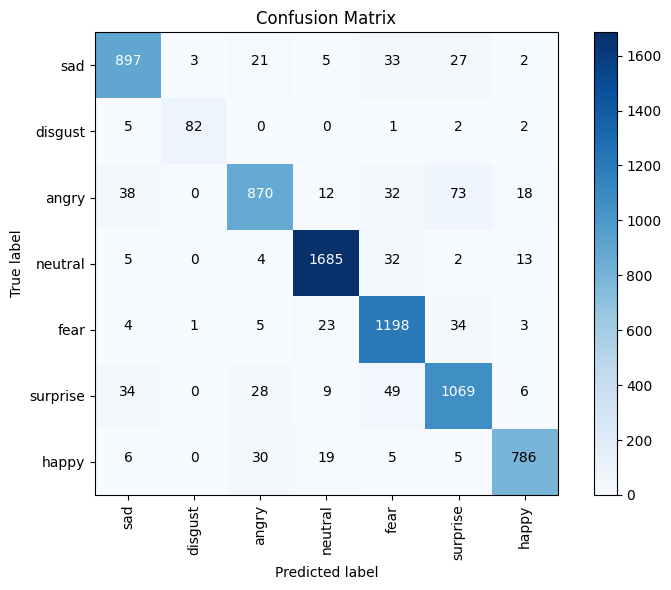


Classification report:

              precision    recall  f1-score   support

         sad     0.9070    0.9079    0.9074       988
     disgust     0.9535    0.8913    0.9213        92
       angry     0.9081    0.8341    0.8696      1043
     neutral     0.9612    0.9678    0.9645      1741
        fear     0.8874    0.9448    0.9152      1268
    surprise     0.8820    0.8946    0.8882      1195
       happy     0.9470    0.9236    0.9352       851

    accuracy                         0.9177      7178
   macro avg     0.9209    0.9092    0.9145      7178
weighted avg     0.9180    0.9177    0.9174      7178



In [ ]:
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy'] # list(set(labels))
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))